In [1]:
import crispat
import pandas as pd
import anndata as ad

In [2]:
data_dir = '../example_data/'

# Prepare data for guide assignment
To apply one of the 11 guide assignment functions of this package, we first have to create and save an AnnData object containing the gRNA counts for all cells. Depending on the format of your input data, this can either be done by using one of our import functions or for more customizability directly using the `anndata` package. In our package, we provide two functions that either read in cellranger output (`create_anndata_from_cellranger`) or a csv file with the gRNA-cell matrix (`create_anndata_from_csv`) to create the .h5ad file. 

## Version 1: create AnnData object from cellranger output 

## Version 2: create AnnData object from a csv file containing the gRNA count matrix 

In [3]:
# Input csv file should look like this: first column contains gRNA names, remaining columns gRNA counts per cell
input_csv = pd.read_csv(data_dir + 'Schraivogel/gRNA_counts.csv')
input_csv.iloc[0:5, 0:5]

,gRNA,TAP1-AAACCTGAGCCTATGT,TAP1-AAACCTGAGGCGTACA,TAP1-AAACCTGAGGGCTTGA,TAP1-AAACCTGAGGGTGTTG
0,CROPseq_dCas9_DS_CCNE2_+_95907328.23-P1P2,0,0,0,0
1,CROPseq_dCas9_DS_CCNE2_+_95907382.23-P1P2,0,0,0,0
2,CROPseq_dCas9_DS_CCNE2_+_95907406.23-P1P2,0,0,0,0
3,CROPseq_dCas9_DS_CCNE2_-_95907017.23-P1P2,0,0,0,0
4,CROPseq_dCas9_DS_CPQ_+_97657557.23-P1P2,0,26,0,0


In [4]:
# this version is only for data sets consisting of a single experimental batch
crispat.create_anndata_from_csv(data_dir + 'Schraivogel/gRNA_counts.csv', data_dir + 'Schraivogel/')

Load data
Create anndata object
Done: AnnData object is saved in ../example_data/Schraivogel/


In [5]:
# the resulting anndata object that is used as input for all guide assignment methods looks like this
ad.read_h5ad(data_dir + 'Schraivogel/gRNA_counts.h5ad')

AnnData object with n_obs × n_vars = 21977 × 86
    obs: 'batch'

# Run guide assignment
This package contains implementations of 11 different guide assignment methods which we grouped into four main categories based on whether information is shared across gRNAs, cells or both.

## Independent
The simplest approach (called `ga_UMI`) is to not share any information across the gRNA-cell matrix and check for each value separately whether it is higher than a fixed threshold. To find a suitable thresholds, a list of thresholds is passed as one argument of the function (UMI threshold of 3, 5 and 7 in the following example).

In [6]:
# Guide assignment with UMI thresholds
crispat.ga_umi(data_dir + 'Schraivogel/gRNA_counts.h5ad', [3,5,7], 
       data_dir + 'guide_assignments/UMI/')

Guide assignment with UMI threshold
Load gRNA counts
Get perturbed cells for each gRNA with UMI threshold = 3
Get perturbed cells for each gRNA with UMI threshold = 5
Get perturbed cells for each gRNA with UMI threshold = 7
Done: outputs are saved in ../example_data/guide_assignments/UMI/


## Across gRNAs
In the next group of methods, information is shared across gRNAs. The simplest approach of this group is to assign for each cell the gRNA with highest counts in this cell (if there is a unique maximum).

In [7]:
# Maximum guide assignment 
crispat.ga_max(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
       data_dir + 'guide_assignments/maximum/')

Guide assignment with maximum assignment
Load gRNA counts
Done: outputs are saved in ../example_data/guide_assignments/maximum/


An adaptation of the maximum approach is to only assign the most abundant gRNA per cell if the counts of this gRNA comprise at least a certain percentage X of the total counts of the cell. The list of percentages X to use as ratio_thresholds is provided as an argument of the function.

In [8]:
# Guide assignment with ratio thresholds
crispat.ga_ratio(data_dir + 'Schraivogel/gRNA_counts.h5ad', [0.3, 0.5, 0.8], 
         data_dir + 'guide_assignments/ratios/')

Guide assignment with ratio assignment
Load gRNA counts
Done: outputs are saved in ../example_data/guide_assignments/ratios/


The following two methods (`ga_2beta` and `ga_3beta`) also use a threshold on the percentages per cell, but learn a threshold for each batch based on the data distribution. In the `ga_2beta` function, a mixture model consisting of two beta distributions is fitted to the distribution of the percentages of the most abundant gRNAs per cell to distinguish the background/noise counts from the counts of actually perturbed cells. The threshold X is determined as the intersection of the densities of the two mixture components. In the `ga_3beta` function, we use a mixture model with 3 components instead of two such that we can additionally model cells that were infected with two gRNAs. Here, the threshold X is chosen as the intersection of the second and third mixture component (numbering them by increasing mean). 

In [9]:
# Guide assignment with 2-Beta mixture model
crispat.ga_2beta(data_dir + 'Schraivogel/gRNA_counts.h5ad', [1], 
         data_dir + 'guide_assignments/2-BetaMM/')

Guide assignment fitting a mixture model of two beta distributions
Load gRNA counts
Fit 2-beta mixture model for each batch:
Batch  1
Done: outputs are saved in ../example_data/guide_assignments/2-BetaMM/


In [10]:
# Guide assignment with 3-Beta mixture model
crispat.ga_3beta(data_dir + 'Schraivogel/gRNA_counts.h5ad', [1], 
         data_dir + 'guide_assignments/3-BetaMM/')

Guide assignment fitting a mixture model of three beta distributions
Load gRNA counts
Fit 3-beta mixture model for each batch:
Batch  1
Done: outputs are saved in ../example_data/guide_assignments/3-BetaMM/


## Across cells
The next group of methods is performed across cells by fitting a mixture model for each gRNA. `ga_cellranger` is based on the cellranger assignment and fits a Gaussian mixture model to the log10-transformed UMI counts for each batch and gRNA.

In [11]:
# Guide assignment with Cellranger approach (Gaussian mixture model)
crispat.ga_cellranger(data_dir + 'Schraivogel/gRNA_counts.h5ad', [1], 
              data_dir + 'guide_assignments/cellranger/')

Guide assignment according to cellranger tool
Load gRNA counts
Fit Gaussian Mixture models for batch 1
Done: outputs are saved in ../example_data/guide_assignments/cellranger/


`ga_replogle` instead uses a Poisson-Gaussian mixture model on the log2-transformed non-zero UMI counts per gRNA similar to the approach by Replogle et al. (Cell, 2022).

In [12]:
# Guide assignment with Replogle approach (Poisson-Gaussian mixture model)
crispat.ga_replogle(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
            data_dir + 'guide_assignments/replogle/')

Guide assignment with Poisson-Gaussian mixture model as in Replogle et al.
Load gRNA counts
Fit Poisson-Gaussian Mixture Model for each gRNA: 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [02:25<00:00,  1.70s/it]

Done: outputs are saved in ../example_data/guide_assignments/replogle/


## Across gRNAs & cells
Finally, in the last group of methods information is shared across gRNAs and across cells.   

Since `ga_SCEPTRE`, `ga_negative_binomial` and `ga_binomial` have the longest run time, these functions can be run in parallel for distinct sets of gRNAs. To do so, use the `start_gRNA` parameter (index of the first gRNA) and the `gRNA_step` paramter which defines the number of gRNAs that are assigned (e.g. with start_gRNA = 0 and step = 2 the assignment is performed for the first two gRNAs of the data set. Note that it is faster to use the mixture model implemented in the SCEPTRE R package instead of our pyro-based version which is used here for comparability across all methods. In SCEPTRE, a Poisson mixture model is fit to the UMI counts per gRNA including additional covariates, which in our case are the sequencing depth and batch effects.

In [13]:
# Guide assignment with SCEPTRE model
crispat.ga_sceptre(data_dir + 'Schraivogel/gRNA_counts.h5ad', [1], 
           data_dir + 'guide_assignments/SCEPTRE/',
           start_gRNA = 0, gRNA_step = 2)

Guide assignment based on SCEPTRE Poisson mixture model
Load gRNA counts
Fit SCEPTRE Poisson Model for each gRNA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:44<00:00, 82.38s/it]

Done: outputs are saved in ../example_data/guide_assignments/SCEPTRE/


`ga_negative_binomial` is an adaption of SCEPTRE in which a Negative Binomial distribution is used instead of the Poisson distribution such that an additional overdispersion parameter is learned. 

In [14]:
# Guide assignment with negative binomial model
crispat.ga_negative_binomial(data_dir + 'Schraivogel/gRNA_counts.h5ad', [1], 
                     data_dir + 'guide_assignments/negative_binomial/',
                     start_gRNA = 0, gRNA_step = 2)

Load gRNA counts data
Fit Negative Binomial Model for each gRNA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:57<00:00, 88.83s/it]

Done: outputs are saved in ../example_data/guide_assignments/negative_binomial/


In `ga_binomial`, a Binomial distribution is used to model the UMI counts distribution. Two parameters are needed to define a Binomial distribution. The first parameter here is the number of total gRNA counts of a cell and the second parameter is a gRNA-specific probability function depending on the perturbation state and the batch of a cell.

In [15]:
# Guide assignment with binomial model
crispat.ga_binomial(data_dir + 'Schraivogel/gRNA_counts.h5ad', [1], 
            data_dir + 'guide_assignments/binomial_test/',
            start_gRNA = 0, gRNA_step = 3)

crispat.ga_binomial(data_dir + 'Schraivogel/gRNA_counts.h5ad', [1], 
            data_dir + 'guide_assignments/binomial_test/',
            start_gRNA = 3, gRNA_step = 3)

Guide assignment fitting a binomial model
Load gRNA counts
Fit Binomial Model for each gRNA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.67s/it]


Done: outputs are saved in ../example_data/guide_assignments/binomial_test/
Guide assignment fitting a binomial model
Load gRNA counts
Fit Binomial Model for each gRNA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.59s/it]

Done: outputs are saved in ../example_data/guide_assignments/binomial_test/


In `ga_quantiles`, the UMI counts are first normalized per cell by dividing by the total gRNA counts per cell. Next, for each gRNA X% of cells with non-zero counts for this gRNA with highest ratios are assigned. A list of ratios X to use has to be provided as one argument of the function.

In [16]:
# Guide assignment with quantiles approach
crispat.ga_quantiles(data_dir + 'Schraivogel/gRNA_counts.h5ad', [0.1, 0.35], 
             data_dir + 'guide_assignments/quantiles/')

Load gRNA counts data
Get cells with highest ratios per gRNA
Done: outputs are saved in ../example_data/guide_assignments/quantiles/


# Method comparison

After running all methods of interest on the full data set (using a high-performance cluster for parallelization), we are loading in the assignment results and filter for cells with a single gRNA assigned. 

In [17]:
# In case parallelization over gRNA subsets has been used, we first have to combine the output files
crispat.combine_assignments(data_dir + 'guide_assignments/binomial_test/', [0,3], [2,5])

In [19]:
# Load all guide calling results (after running all methods on the full data set)
# Create dictionary with user-chosen method names as keys and a list of the directory name and threshold as values
ga_dict = {'2-Beta': ['2-BetaMM', None],
           '3-Beta': ['3-BetaMM', None],
           'Binomial': ['binomial', None], 
           'Cellranger': ['cellranger/batch1', None], 
           'Maximum': ['maximum', None], 
           'Negative Binomial': ['negative_binomial', None], 
           'Replogle': ['Replogle', None], 
           'SCEPTRE': ['SCEPTRE', None],
           'UMI_t7': ['UMI', 7],
           'ratio_50%': ['ratios', 0.5],
           'top_35%_cells': ['quantiles', 0.35]}

perturbations = crispat.load_assignments(ga_dict, data_dir + 'guide_assignments/')

# Filter for cells with single gRNA assigned
single_perturbations = perturbations.groupby(['method', 'cell']).filter(lambda x: len(x) == 1)
single_perturbations.to_csv(data_dir+'guide_assignments/single_assignments_all_methods.csv', index = False)

## Number of assigned cells and intersection heatmap

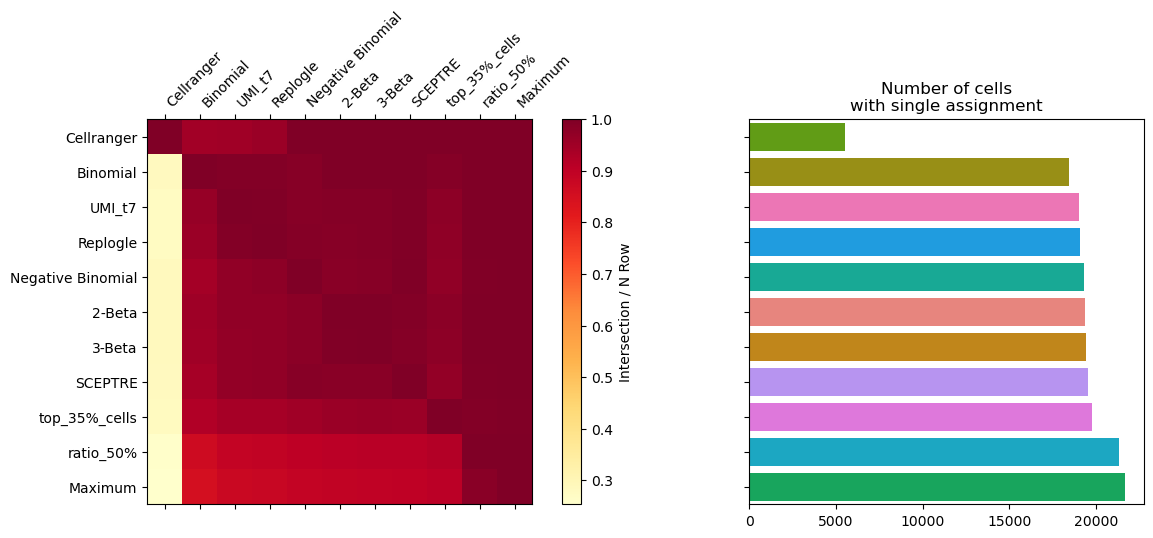

In [20]:
# Dictionary of colors to use for the barplot on the right
colors = {'2-Beta': '#F8766D', '3-Beta': '#DB8E00', 'Binomial': '#AEA200', 'Cellranger': '#64B200',
          'Maximum': '#00BD5C', 'Negative Binomial': '#00C1A7', 'ratio_50%': '#00BADE',
          'Replogle': '#00A6FF', 'SCEPTRE': '#B385FF', 'top_35%_cells': '#EF67EB', 'UMI_t7': '#FF63B6'}

crispat.plot_intersection_heatmap(single_perturbations, colors)

## Effects on downstream analyses

The effects on the downstream analysis were evaluated using the R package SCEPTRE, but also any other tool of interest could be used for this step. For our analyses, we chose to use SCEPTRE since it combines multiple analyses and control checks in a statistical rigorous fashion. First, SCEPTRE calculates the log2 fold changes and p-values for the target genes (power check). Next, it calculates the number of false discoveries which are genes that are significantly differentially expressed comparing the cells of one non-targeting gRNA against all other non-targeting control cells (calibration). And finally, it calculates the differentially expressed genes for each perturbation (discovery analysis). The script SCEPTRE_discovery.R shows how to input your own assignment into SCEPTRE to use their pipeline. A comparison of all our results is shown in downstream_comparison.Rmd.